In [ ]:
'''
Pending:
- Try k-clustering
'''

# Exploring ACLED data
- Import excel file, add date column and export it as json
- Use json file for all future work
- Data formatting: column names. 
- Encode event_type and sub_event_type
- Aggregate by month
- Function to get a dataset for a specific country

In [1]:
# African dataset
# https://www.acleddata.com/curated-data-files/

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

## Exporting excel file as json

In [3]:
# # import excel file
# df = pd.read_excel('../data/Africa_1997-2019_Oct12-1.xlsx')

In [4]:
# # New column for date
# df['date'] = pd.to_datetime(df['EVENT_DATE']).dt.date

In [5]:
# # export dataframe as json
# df.to_json('../data/africa-data.json')

## Importing data

In [6]:
df = pd.read_json('../data/africa-data.json')

In [7]:
df.shape

(193565, 30)

In [8]:
df.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP,date
0,12,ALG1,1,852076800000,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,None,...,Douaouda,36.672,2.789,1,Algeria Watch,Other,5 January: Beheading of 5 citizens in Douaouda...,5,2019-09-02 22:08:55,1997-01-01
1,12,ALG2,2,852163200000,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,None,...,Hassasna,36.133,0.883,1,Algeria Watch,Other,Two citizens were beheaded in Hassasna.,2,2019-09-02 22:08:55,1997-01-02
10,12,ALG9,9,852595200000,1997,1,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,None,...,Algiers,36.752,3.042,1,Algeria Watch,Other,7 January: Explosion of a bomb in the Didouche...,20,2019-09-02 22:08:55,1997-01-07
100,12,ALG101,101,872812800000,1997,1,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,None,...,Casbah,36.785,3.059,1,Algeria Watch,Other,29 August: Bomb explosion in the working-class...,13,2019-09-02 22:08:55,1997-08-29
1000,12,ALG1005,1005,1047081600000,2003,1,Violence against civilians,Abduction/forced disappearance,GSPC: Salafist Group for Call and Combat,None,...,Tamanrasset,22.785,5.523,3,AFP,International,March 8: Four German tourists disappear in cen...,0,2019-06-25 13:22:37,2003-03-08


## Data formatting
- Rename columns
- Encode values
- Define classification according to event/fatalities?

In [9]:
# Rename and remove columns
columns = ['YEAR', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'REGION', 'COUNTRY', 'SOURCE', 'FATALITIES', 'date']
try:
    df = df[columns]
    df.columns = ['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date']
except KeyError as e:
    print(e)
    pass

print(df.columns)
print(df.shape)

Index(['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country',
       'source', 'fatalities', 'date'],
      dtype='object')
(193565, 9)


In [10]:
# Encode event_types and sub_event_types
# https://www.datacamp.com/community/tutorials/categorical-data

In [11]:
print('**Categorical values**\n')
print('{} event types:\n {}\n'.format(df.event_type.nunique(), df.event_type.unique()))
print('{} sub_event types:\n {}\n'.format(df.sub_event_type.nunique(), df.sub_event_type.unique()))
print('{} actors:\n {}\n'.format(df.actor.nunique(), df.actor.unique()))

**Categorical values**

6 event types:
 ['Violence against civilians' 'Explosions/Remote violence'
 'Strategic developments' 'Battles' 'Protests' 'Riots']

25 sub_event types:
 ['Attack' 'Remote explosive/landmine/IED' 'Abduction/forced disappearance'
 'Non-violent transfer of territory' 'Armed clash'
 'Looting/property destruction' 'Headquarters or base established'
 'Peaceful protest' 'Non-state actor overtakes territory'
 'Government regains territory' 'Protest with intervention'
 'Change to group/activity' 'Mob violence' 'Violent demonstration'
 'Sexual violence' 'Arrests' 'Air/drone strike'
 'Shelling/artillery/missile attack' 'Disrupted weapons use'
 'Excessive force against protesters' 'Agreement' 'Other' 'Grenade'
 'Suicide bomb' 'Chemical weapon']

4065 actors:
 ['GIA: Armed Islamic Group' 'GSPC: Salafist Group for Call and Combat'
 'Unidentified Armed Group (Angola)' ...
 'AFRC: Armed Forces Revolutionary Council (Advance Teams)'
 'Kakula Militia' 'Militia (Superman Faction)'

In [12]:
# Selecting labels for baseline model
labels = ['event_type','sub_event_type']
labels = df[labels]
labels.head()

,event_type,sub_event_type
0,Violence against civilians,Attack
1,Violence against civilians,Attack
10,Explosions/Remote violence,Remote explosive/landmine/IED
100,Explosions/Remote violence,Remote explosive/landmine/IED
1000,Violence against civilians,Abduction/forced disappearance


In [13]:
##### Encoding Labels

In [14]:
# Adding a boolean column for fatalities

df['fatalities_encoded'] = np.where(df['fatalities']>0, '1', '0')
df.head()

,year,event_type,sub_event_type,actor,region,country,source,fatalities,date,fatalities_encoded
0,1997,Violence against civilians,Attack,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,5,1997-01-01,1
1,1997,Violence against civilians,Attack,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,2,1997-01-02,1
10,1997,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,20,1997-01-07,1
100,1997,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,13,1997-08-29,1
1000,2003,Violence against civilians,Abduction/forced disappearance,GSPC: Salafist Group for Call and Combat,Northern Africa,Algeria,AFP,0,2003-03-08,0


In [15]:
# del df['fatalities_encoded']

In [16]:
# Using get_dummies for values with more than two levels

labels_encoded = pd.get_dummies(labels)

In [17]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)
all_labels = pd.concat([labels, labels_encoded], axis=1, sort=False)
# all_labels.iloc[2]

In [18]:
df = pd.concat([df, labels_encoded], axis = 1, sort = False)
# df.iloc[1]

## Function: get data for a country
- Filter data by country. 
- Aggregate by month. 
- Basic plot

In [31]:
'''
Function to get data for one specific country.
Plot data in a timeline
Get basic statistics
'''

def country_data(data, name_country = ""):
    global df_country
    plt.rcParams['figure.figsize'] = (15, 8)
    
    try:
        df_country = data.query('country == "{}"'.format(name_country))
        event_type = df_country.groupby(['date'])['event_type'].count()
        
        #graph
        event_type.plot(subplots=True, figsize=(20, 10), style='.', alpha=0.5)
        print("{} of events in {}, {} fatalities (1997-2019)".\
              format(df_country['event_type'].count(), name_country, df_country.fatalities.sum()))

    except NameError as e:
        print("Error")
        pass
    
#     return df_country, event_type

15208 of events in Nigeria, 72663 fatalities (1997-2019)


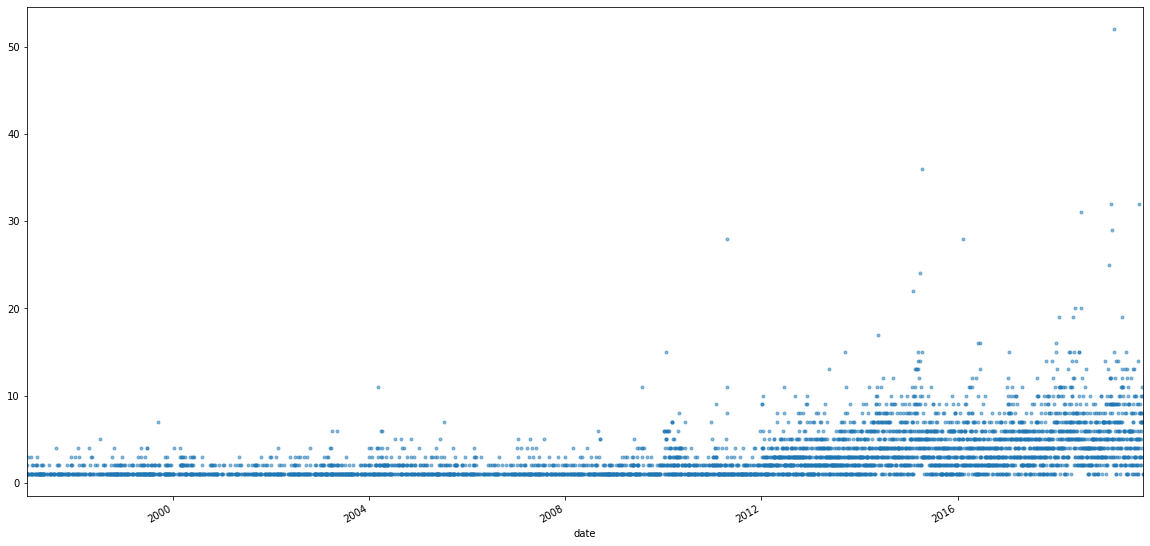

In [33]:
country_data(df, 'Nigeria')

## ML models

In [ ]:
# Using k-clustering to find anomalies compare to previous month
# https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

# Appendix: Data exploration

In [ ]:
# Plot variables sns
plt.rcParams['figure.figsize'] = (15, 8)

In [ ]:
print('Event types: {}\n'.format(df['event_type'].unique()))
print('Event subtypes: {}'.format(df['sub_event_type'].unique()))

In [ ]:
# Events
sns.countplot(x='event_type', color='lightcoral', data=df)

In [ ]:
# Plotting time series
# https://www.kaggle.com/lordkada/acled-simple-analysis

# All event 1997 - 2019
event_type = df.groupby(['date'])['event_type'].count()
event_type.plot(subplots=True, figsize=(20, 10), style='.', alpha=0.5)
print("1997-2019 - Number of events in {} countries: {}".
      format(df['country'].nunique(), df['event_type'].count()))

In [ ]:
# All subevents by date
sub_events = df.groupby(['date', 'sub_event_type'])['sub_event_type', ].count()
sub_events.reset_index(level=['date'], inplace= True)
sub_events.head()

In [ ]:
year = df.groupby(['year'])['event_type'].count()
year.plot(kind='bar', color = 'lightcoral')

In [ ]:
# Use rolling to deseasonalize data 
event_type['1999'].plot(figsize=(20,10), linewidth=5, fontsize=20, style='x', alpha = 0.5)
event_type['1999'].rolling(12).mean().plot(figsize=(20,10), linewidth=2, fontsize=20, alpha = 0.5)


In [ ]:
# Plot peaks/diff in data
event_type.plot(figsize=(20,10), linewidth=5, fontsize=20, style='.', alpha=0.2 )
event_type.diff().plot(figsize=(20,10), linewidth=1, fontsize=20, alpha=0.4 )